*Marcello Victorino* <br>
*04/30/2019* -  

# Introduction
This project is part of a requirement to graduate in the Udacity's Data Analyst Nanodegree (*DAND*).

It provides the opportunity to implement Data Wrangling in practice by gathering data from different sources, assessing it for quality and tidiness issues and then promote the necessary cleaning task - programatically.

Finally, once the data is properly cleaned and stored, a brief analysis is conducted with visualizations, highlighting interesting insights.

The data for this project was provided in partnership with the **WeRateDogs** channel from twitter, containing over 5,000 observations about dogs.

In [1]:
import pandas as pd
import numpy as np

## Gather

In [2]:
# Gathering Twitter Enhanced Archive data
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [3]:
# Gathering Image Predictions for Dog Breed - Available online
import requests
import os

# Avoid redownloading if file already saved locally
if 'image_predictions.txt' in os.listdir():
    pass

else:
    url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

    # Accessing file online
    r = requests.get(url)

    # Saving content locally
    with open('image_predictions.txt', 'wb') as fh:
        fh.write(r.content)

# Reading Dog Breed data
df_breed = pd.read_csv('image_predictions.txt', sep='\t')

df_breed.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [4]:
# Gathering data from Twitter API
import tweepy
from twitter_secret_credentials import Twitter_API_Authenticate # personal script

# Authenticating connection to Twitter API
api = Twitter_API_Authenticate() # wait_on_rate_limit=True, wait_on_rate_limit_notify=True

In [5]:
# Retrieve data from Twitter ID (JSON format)
import json
from tqdm import tqdm_notebook as progressbar

# Avoid redownloading if file already saved locally
if 'tweet_json.txt' in os.listdir():
    print('JSON data has already been downloaded.')
    pass

else:
    # Retrieve data from Twitter API and save locally
    fails = []
    count = 0
    with open('tweet_json.txt', 'w') as file:
        for tweet_id in progressbar(df_archive.tweet_id[:]):
            count += 1
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                json.dump(tweet._json, file)
                file.write('\n') # important to separate each tweet  

            except:
                fails.append(tweet_id)

    fail_percentage = len(fails)/count
    print(f'Successfully read: {(1 - fail_percentage):.0%}') # 19 tweets could not be read | 25 minutes

JSON data has already been downloaded.


In [6]:
# Actually working with the JSON data extracted

# Avoid duplicating work if data already parsed and saved locally
if 'tweet_parsed_data.csv' in os.listdir():
    print('Data already parsed and saved.')
    df_tweet = pd.read_csv('tweet_parsed_data.csv')

else:
    with open('tweet_json.txt', 'r') as file:
        tweet_jsons = file.readlines()

    # Iterating over each individual tweet
    tweet_data = list()

    for tweet in tweet_jsons:
        data = dict()

        js = json.loads(tweet) # Reading each tweet string as JSON
        
        # Skip text starting with "RT" or "@"
        if js['full_text'].startswith(('RT', '@')):
            continue

    #         print(json.dumps(js, indent=4)) # Pretty printing JSON
        data['tweet_id'] = js['id_str']
        data['created'] = js['created_at']
        data['retweet'] = js['retweet_count']
        data['favorite'] = js['favorite_count']
        data['text'] = js['full_text']

        tweet_data.append(data)

    # Reading data into Dataframe
    df_tweet = pd.DataFrame(tweet_data, columns=data.keys())

### Using data already available via twitter_archive_enhanced
#     # Extract dog's name
#     df_tweet['name'] = df_tweet.text.str.extract(' ([A-Z][a-z]*)')

### Using data already available via twitter_archive_enhanced  
    # Extract rating
#     df_tweet['rate'] = df_tweet.text.str.extract('([0-9]*)/[0-9]{2}')

    # Transforming df_tweet.created as Datetime
    df_tweet.created = pd.to_datetime(df_tweet.created)

    # Extract datetime from Created feature
    df_tweet['year'] = df_tweet.created.dt.year
    df_tweet['month'] = df_tweet.created.dt.month
    df_tweet['weekday'] = df_tweet.created.dt.day_name()
    df_tweet['hour'] = df_tweet.created.dt.hour

    # Saving it locally
    df_tweet.to_csv('tweet_parsed_data.csv', index=False)

df_tweet.tweet_id = df_tweet.tweet_id.astype(str)
df_tweet.head(2)

Data already parsed and saved.


,tweet_id,created,retweet,favorite,text,year,month,weekday,hour
0,892420643555336193,2017-08-01 16:23:56+00:00,8197,37569,This is Phineas. He's a mystical boy. Only eve...,2017,8,Tuesday,16
1,892177421306343426,2017-08-01 00:17:27+00:00,6060,32304,This is Tilly. She's just checking pup on you....,2017,8,Tuesday,0


## Data Assessment and Cleaning

### 1) Twitter Archived Enhanced Dataset
#### Define
Tidiness:
+ Multiple stage categories (puppo, fluffer etc.) in separate columns -> should be melted into a single Category variable

Quality:
+ tweet_id stored as integer -> should be as string
+ Many columns filled with missing values or useless data -> remove 7 columns: ['in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'retweeted_status_id', retweeted_status_user_id', retweeted_status_timestamp', 'expanded_urls']
+ Replace 'None' entries with `np.NaN`
+ Store `rate` as integer
+ Remove `rate` entries > 50 (odd entries or jokes)
+ Missing values in Name column (there is nothing we can do. Some tweets do not have the dog's name)

In [7]:
# Checking for duplicates
df_archive.duplicated().sum()

0

In [8]:
# Checking datatype and missing data
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

#### Code

In [9]:
# Tidy: grouping many columns into a single one
# Obs: pd.melt did not accomplish what I wanted

# Creating copy before cleaning

df_archive_clean = df_archive.copy()
df_archive_clean['category'] = np.where(df_archive_clean.doggo != 'None', 'doggo',
                            np.where(df_archive.floofer != 'None', 'floofer',
                            np.where(df_archive.pupper != 'None', 'puper',
                            np.where(df_archive.puppo != 'None', 'puppo', np.NaN))))

# Quality: Dropping irrelavant or columns already available in other dataset
df_archive_clean.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_denominator', 'doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

# Quality: Store ID as string for later joining reference
df_archive_clean.tweet_id = df_archive_clean.tweet_id.astype(str)

# Quality: Replace 'None' entries with NaN
df_archive_clean.replace('None', np.NaN, inplace=True)

# Remove odd ratings
df_archive_clean = df_archive_clean.query('rating_numerator < 50')

# Store rate as integer
df_archive_clean.rating_numerator = df_archive_clean.rating_numerator.astype(int)

#### Test

In [10]:
# Test if rate is integer
assert df_archive_clean.rating_numerator.dtype.kind == 'i'

In [11]:
# Test if only rates < 50
assert (df_archive_clean.rating_numerator < 50).all()

In [12]:
df_archive_clean.loc[8:13]

,tweet_id,rating_numerator,name,category
8,890609185150312448,13,Zoey,nan
9,890240255349198849,14,Cassie,doggo
10,890006608113172480,13,Koda,nan
11,889880896479866881,13,Bruno,nan
12,889665388333682689,13,NaN,puppo
13,889638837579907072,12,Ted,nan


### 2) Dog Breed
#### Define
Tidiness: N/A

Quality:
+ Remove irrelevant columns -> ['p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']
+ Remove entries with Confidence Score <= 59% -> horribly inaccurate dog breed
+ Remove entries Not Dog -> Dog = False
+ Store tweet_id as string

In [13]:
# Checking for duplicates
df_breed.duplicated().sum()

0

In [14]:
# Checking datatype and missing data
df_breed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [15]:
# Creating copy before cleaning
df_breed_clean = df_breed.copy()

# Removing irrelevant columns
df_breed_clean.drop(columns=['p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], inplace=True)

# Remove observations with confidence score lower than 59% -> incorrect dog breed
df_breed_clean = df_breed_clean.query('p1_conf >= 0.59')

# Remove observations not containg a dog
df_breed_clean = df_breed_clean.query('p1_dog == True')

# Store tweet_id as string
df_breed_clean.tweet_id = df_breed_clean.tweet_id.astype(str)

len(df_breed_clean) # Total of 810 entries with "Good Accurate" data

810

#### Test

In [16]:
# Test for Confidence Score
assert (df_breed_clean.p1_conf >= 0.59).all()

In [17]:
# Test for is Dog
assert (df_breed_clean.p1_dog == True).all()

In [18]:
# Test if tweet_id is string (object in Pandas)
assert df_breed_clean.tweet_id.dtype.kind == 'O'

In [19]:
df_breed_clean.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True


### 3) Scraped Twitter API
#### Define
Tidiness: N/A

Quality:
+ Store `tweet_id` as string

In [20]:
# Checking duplicates
df_tweet.duplicated().sum()

0

In [21]:
# Checking data type and missing data
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2146 entries, 0 to 2145
Data columns (total 9 columns):
tweet_id    2146 non-null object
created     2146 non-null object
retweet     2146 non-null int64
favorite    2146 non-null int64
text        2146 non-null object
year        2146 non-null int64
month       2146 non-null int64
weekday     2146 non-null object
hour        2146 non-null int64
dtypes: int64(5), object(4)
memory usage: 151.0+ KB


#### Code

In [22]:
# Creating copy before cleaning
df_tweet_clean = df_tweet.copy()

# Store tweet_id as string
df_tweet_clean.tweet_id = df_tweet_clean.tweet_id.astype(str)

#### Test

In [23]:
# Test if tweet_id is string (object in Pandas)
assert df_tweet_clean.tweet_id.dtype.kind == 'O'

In [24]:
df_tweet_clean.head(2)

,tweet_id,created,retweet,favorite,text,year,month,weekday,hour
0,892420643555336193,2017-08-01 16:23:56+00:00,8197,37569,This is Phineas. He's a mystical boy. Only eve...,2017,8,Tuesday,16
1,892177421306343426,2017-08-01 00:17:27+00:00,6060,32304,This is Tilly. She's just checking pup on you....,2017,8,Tuesday,0


### Overall Tidiness Evaluation
A dataset is defined as tidy if:
+ Each observation forms a row
+ Each variable forms a column and contains values
+ Each type of observational unit forms a table

In this case, I understand the existing 3 datasets should be rearranged into 2 tables:
1. **Tweet data**: tweet_id, creation time, retweet count, favorite count, text, rating
2. **Dog data**: tweet_id, breed, name, category, jpg_url

In [25]:
# Creating Table Tweet Data
tweet_data = df_tweet_clean

### Save final dataset as Final Tweet Data.csv
tweet_data.to_csv('Final Tweet Data.csv', index=False)

In [26]:
# Data regarding dog stage
df_archive_clean.category.value_counts()

nan        1957
puper       245
doggo        97
puppo        29
floofer       9
Name: category, dtype: int64

Since there is not enough data for this variable ("Dog Stage"), I will remove it from the analysis.

In [27]:
## Creating Table Dog Data

# Merging 2 datasets as a Left Join, keeping all data from Left, even if not present in right
dog_data = pd.merge(df_archive_clean, df_breed_clean, on='tweet_id', how='inner')

# Removing useless columns
dog_data.drop(columns=['img_num', 'p1_dog', 'category'], inplace=True)

# Renaming columns to have more meaningful name
dog_data.rename(columns={'p1': 'breed', 'p1_conf': 'confidence_score'}, inplace=True)

# Rounding confidence score to 2 decimals
dog_data.confidence_score = round(dog_data.confidence_score, 2)

### Save final dataset as Final Dog Data.csv
dog_data.to_csv('Final Dog Data.csv', index=False)

## Final Combined and Cleaned Dataset - Master

In [28]:
# Creating Master file keeping only observations with all data available -> 774 entries
twitter_archive_master = pd.merge(tweet_data, dog_data, on='tweet_id', how='inner')
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

In [29]:
len(twitter_archive_master)

774

<hr>

# Data Analysis
After Wrangling the data, it is finally time to analyze the final cleaned dataset to extract insights.

The research questions driving this investigations are as following:
1. What are the top 5 most common dog breeds?
1. What are the top 5 most liked dog breeds?
1. What are the top 5 most popular/common dog names?
1. Is there a specific time associated with higher creation of tweets/ratings?

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Q1) Most Common Dog Breeds

In [31]:
# Easier to refer to dataframe
df = twitter_archive_master

In [32]:
top5_common_breeds = pd.DataFrame()
top5_common_breeds['breeds'] = df.breed.value_counts()[:5]
top5_common_breeds['percentage'] = round(top5_common_breeds/len(df), 2)

In [46]:
top5_sum = top5_common_breeds.percentage.sum()
print(f'The Top 5 most common dog breeds represent {top5_sum:.0%} of the dataset.')
top5_common_breeds

The Top 5 most common dog breeds represent 39% of the dataset.


,breeds,percentage
golden_retriever,105,0.14
Pembroke,59,0.08
Labrador_retriever,54,0.07
Chihuahua,40,0.05
pug,38,0.05


The Top 5 most common breeds represent almost 40% of the dataset, having the beatiful Golden Retriever as the undisputed first place with 105 tweets submitted/rated!

## Q2) Most Liked Dog Breeds
Instead of simply looking at the number of times a specific breed has been rated, this time we investigate the breeds most retweeted and favorited:

In [34]:
df['popularity'] = df.retweet + df.favorite

In [47]:
# Grouping by dog breed and sorting by median Popularity
top_popular_breeds = df.pivot_table(index='breed', values='popularity', aggfunc=['median','count'])\
    .sort_values(by=('median', 'popularity'), ascending=False).round(0)

# Filtering top 10
top_popular_breeds.head(10)

,median,count
,popularity,popularity
breed,,
black-and-tan_coonhound,39941.0,1
Newfoundland,27450.0,1
Greater_Swiss_Mountain_dog,25508.0,1
Afghan_hound,21276.0,1
Cardigan,20917.0,9
Leonberg,19562.0,2
bloodhound,19391.0,2
Great_Pyrenees,16990.0,8


In this particular case I decided to adopt the *median* instead of the mean, in order to avoid the influence of extreme values (like the swimming labrador retriever tweet that is clearly an outlier based on the number of retweets and favorites).

Although I am a big Labrador and Golden retriever fan, this approach seems more accurate to me... and it leads to an ugly truth:
> The majority of people love **huge-clumsy-goofy-looking dogs**!  😂

Particularly, the Top 4 most liked dog breeds are:
1. [Black and Tan Coonhound](https://images.app.goo.gl/9QxpqBYJvsK1W5pJ6)
2. [Newfoundland](https://images.app.goo.gl/3QMddcz9Gcffkuxg8)
3. [Greater Swiss Mountain Dog](https://images.app.goo.gl/CkjBkwJpMeWdG6GG7)
4. [Afghan Hound](https://images.app.goo.gl/W8LuRRESmPzpmHvT7)
5. Having a **Small-funny-looking** [Cardigan](https://images.app.goo.gl/dPUK1iKQKkSuXXSL9) in the Fifth Place - well deserved!

## Q3) Most Popular Dog Names

In [36]:
df.name.value_counts()[1:6]

Oliver     7
Daisy      5
Cooper     5
Sadie      4
Winston    4
Name: name, dtype: int64

## Q4) Most Typical Tweet Date/Time

In [37]:
df.head(1)

,tweet_id,created,retweet,favorite,text,year,month,weekday,hour,rating_numerator,name,jpg_url,breed,confidence_score,popularity
0,891815181378084864,2017-07-31 00:18:03+00:00,4008,24347,This is Archie. He is a rare Norwegian Pouncin...,2017,7,Monday,0,12,Archie,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.72,28355


Average Posts per Month: 35


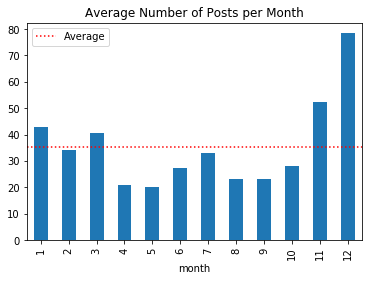

In [38]:
# Number of Posts per Month
month_pop = df.pivot_table(index='year', columns='month', aggfunc='count').hour.mean()
month_pop.plot(kind='bar', label='_na')
plt.axhline(month_pop.mean(), ls=':', c='r', label='Average')
plt.legend()
plt.title('Average Number of Posts per Month');

print(f'Average Posts per Month: {month_pop.mean():.0f}')

Looks like the busiest months are from **November through March**, where the amount of posts is above the average of 35 post per month.

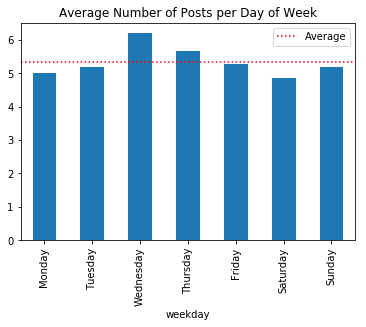

In [39]:
# Number of Posts per Day of Week
hour_pop = df.pivot_table(index=['year', 'month'], columns='weekday', aggfunc='count').hour.mean()

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

hour_pop.loc[day_order].plot(kind='bar', label='_na')
plt.axhline(hour_pop.mean(), ls=':', c='r', label='Average')
plt.legend()
plt.title('Average Number of Posts per Day of Week');

Interestingly, the busiest days are not the weekend! As a matter of fact, **Wednesday and Thursday** are typically the week days with above the average number of posts.

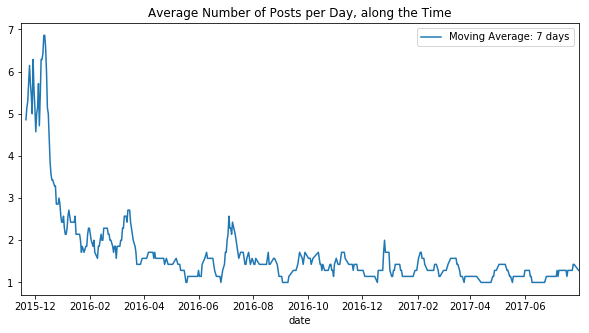

In [40]:
# Amount of Posts along the time

# Set created to DateTime
df.created = pd.to_datetime(df.created)

# Extract Date (YYYY-MM-DD)
df['date'] = df.created.dt.date

# Moving average of last 7 days, over amount of posts per day
df.groupby('date').hour.count().rolling(7).mean().plot(figsize=(10,5), label='Moving Average: 7 days')
plt.title('Average Number of Posts per Day, along the Time')
plt.legend();

Looking at the average number of posts per day, it is possible to see the diminishing trend along the time.
One possible explanation would be that, perhaps, the *WeRateDogs* is losing popularity.